In [ ]:
import numpy as np
import pandas as pd
from skorch import NeuralNetRegressor
import torch
import torch.nn as nn
import torch.optim as optim

# Load dataset
df = pd.read_csv('data/rnn/seattle-weather.csv')  # Replace with your dataset path

df.head()


,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [647]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [648]:
df.duplicated().sum()

np.int64(0)

In [649]:
training_set = df.iloc[:,2:3].values
training_set

array([[12.8],
       [10.6],
       [11.7],
       ...,
       [ 7.2],
       [ 5.6],
       [ 5.6]])

In [650]:
def df_to_XY(df, window_size=10):
    X_train = np.array([df[i - window_size:i, 0] for i in range(window_size, len(df))])
    y_train = np.array([df[i, 0] for i in range(window_size, len(df))])
    return X_train, y_train


X,y = df_to_XY(training_set)
print(len(X),len(y))
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
x_test = y[1000:]

1451 1451


In [651]:
print(X_train.shape, y_train.shape)

(800, 10) (800,)


In [653]:
X_train = torch.tensor(np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)), dtype=torch.float32)
X_val = torch.tensor(np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1)), dtype=torch.float32)
X_test = torch.tensor(np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1)), dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
y_val = torch.tensor(y_val.reshape(-1,1), dtype=torch.float32)

In [654]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size  # Ensure hidden_size is correctly assigned
        self.num_layers = num_layers    # Ensure num_layers is correctly assigned
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0., nonlinearity="relu") 
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Take the last output for prediction
        return out

In [655]:
# Model hyperparameters
input_size = X_train.shape[2]
hidden_size = 50
num_layers = 4
output_size = 1

# Instantiate the PyTorch model
pytorch_model = RNNModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)


In [656]:
from skorch.helper import predefined_split
from skorch.dataset import Dataset


valid_ds = Dataset(X_val, y_val)
# Define Skorch wrapper
net = NeuralNetRegressor(
    pytorch_model,
    max_epochs=100,
    lr=0.001,
    batch_size=32,
    optimizer=optim.Adam,
    train_split=predefined_split(valid_ds)
)

# Train the model
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      238.2388       54.8609  0.0655
      2       24.1364       21.8400  0.0576
      3       13.6232       28.2210  0.0570
      4       13.7681       17.1387  0.0568
      5       12.3183       20.1640  0.0579
      6       12.5517       16.6370  0.0573
      7       11.6261       16.3307  0.0605
      8       10.8739       17.5775  0.0559
      9       10.6483       13.8112  0.0559
     10        9.6081       12.9648  0.0556
     11        8.8491       13.4798  0.0561
     12        8.7408       12.0826  0.0561
     13        8.3466       11.5284  0.0561
     14        8.1201       11.8431  0.0557
     15        8.0664       11.5430  0.0558
     16        7.9758       11.6611  0.0559
     17        7.9668       11.4511  0.0858
     18        7.8841       11.6230  0.0558
     19        7.9363       11.6879  0.0562
     20        7.8777       11.6373  0.0555
     21        7.8986       12.1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RNNModel(
    (rnn): RNN(1, 50, num_layers=4, batch_first=True)
    (fc): Linear(in_features=50, out_features=1, bias=True)
  ),
)

In [657]:
train_pred = net.predict(X_train).flatten()
val_pred = net.predict(X_val).flatten()
test_pred = net.predict(X_test).flatten()

In [658]:
# train_pred = scaler_ytrain.inverse_transform(net.predict(X_train)).flatten()
# val_pred = scaler_ytrain.inverse_transform(net.predict(X_val)).flatten()
# test_pred = scaler_ytrain.inverse_transform(net.predict(X_test)).flatten()

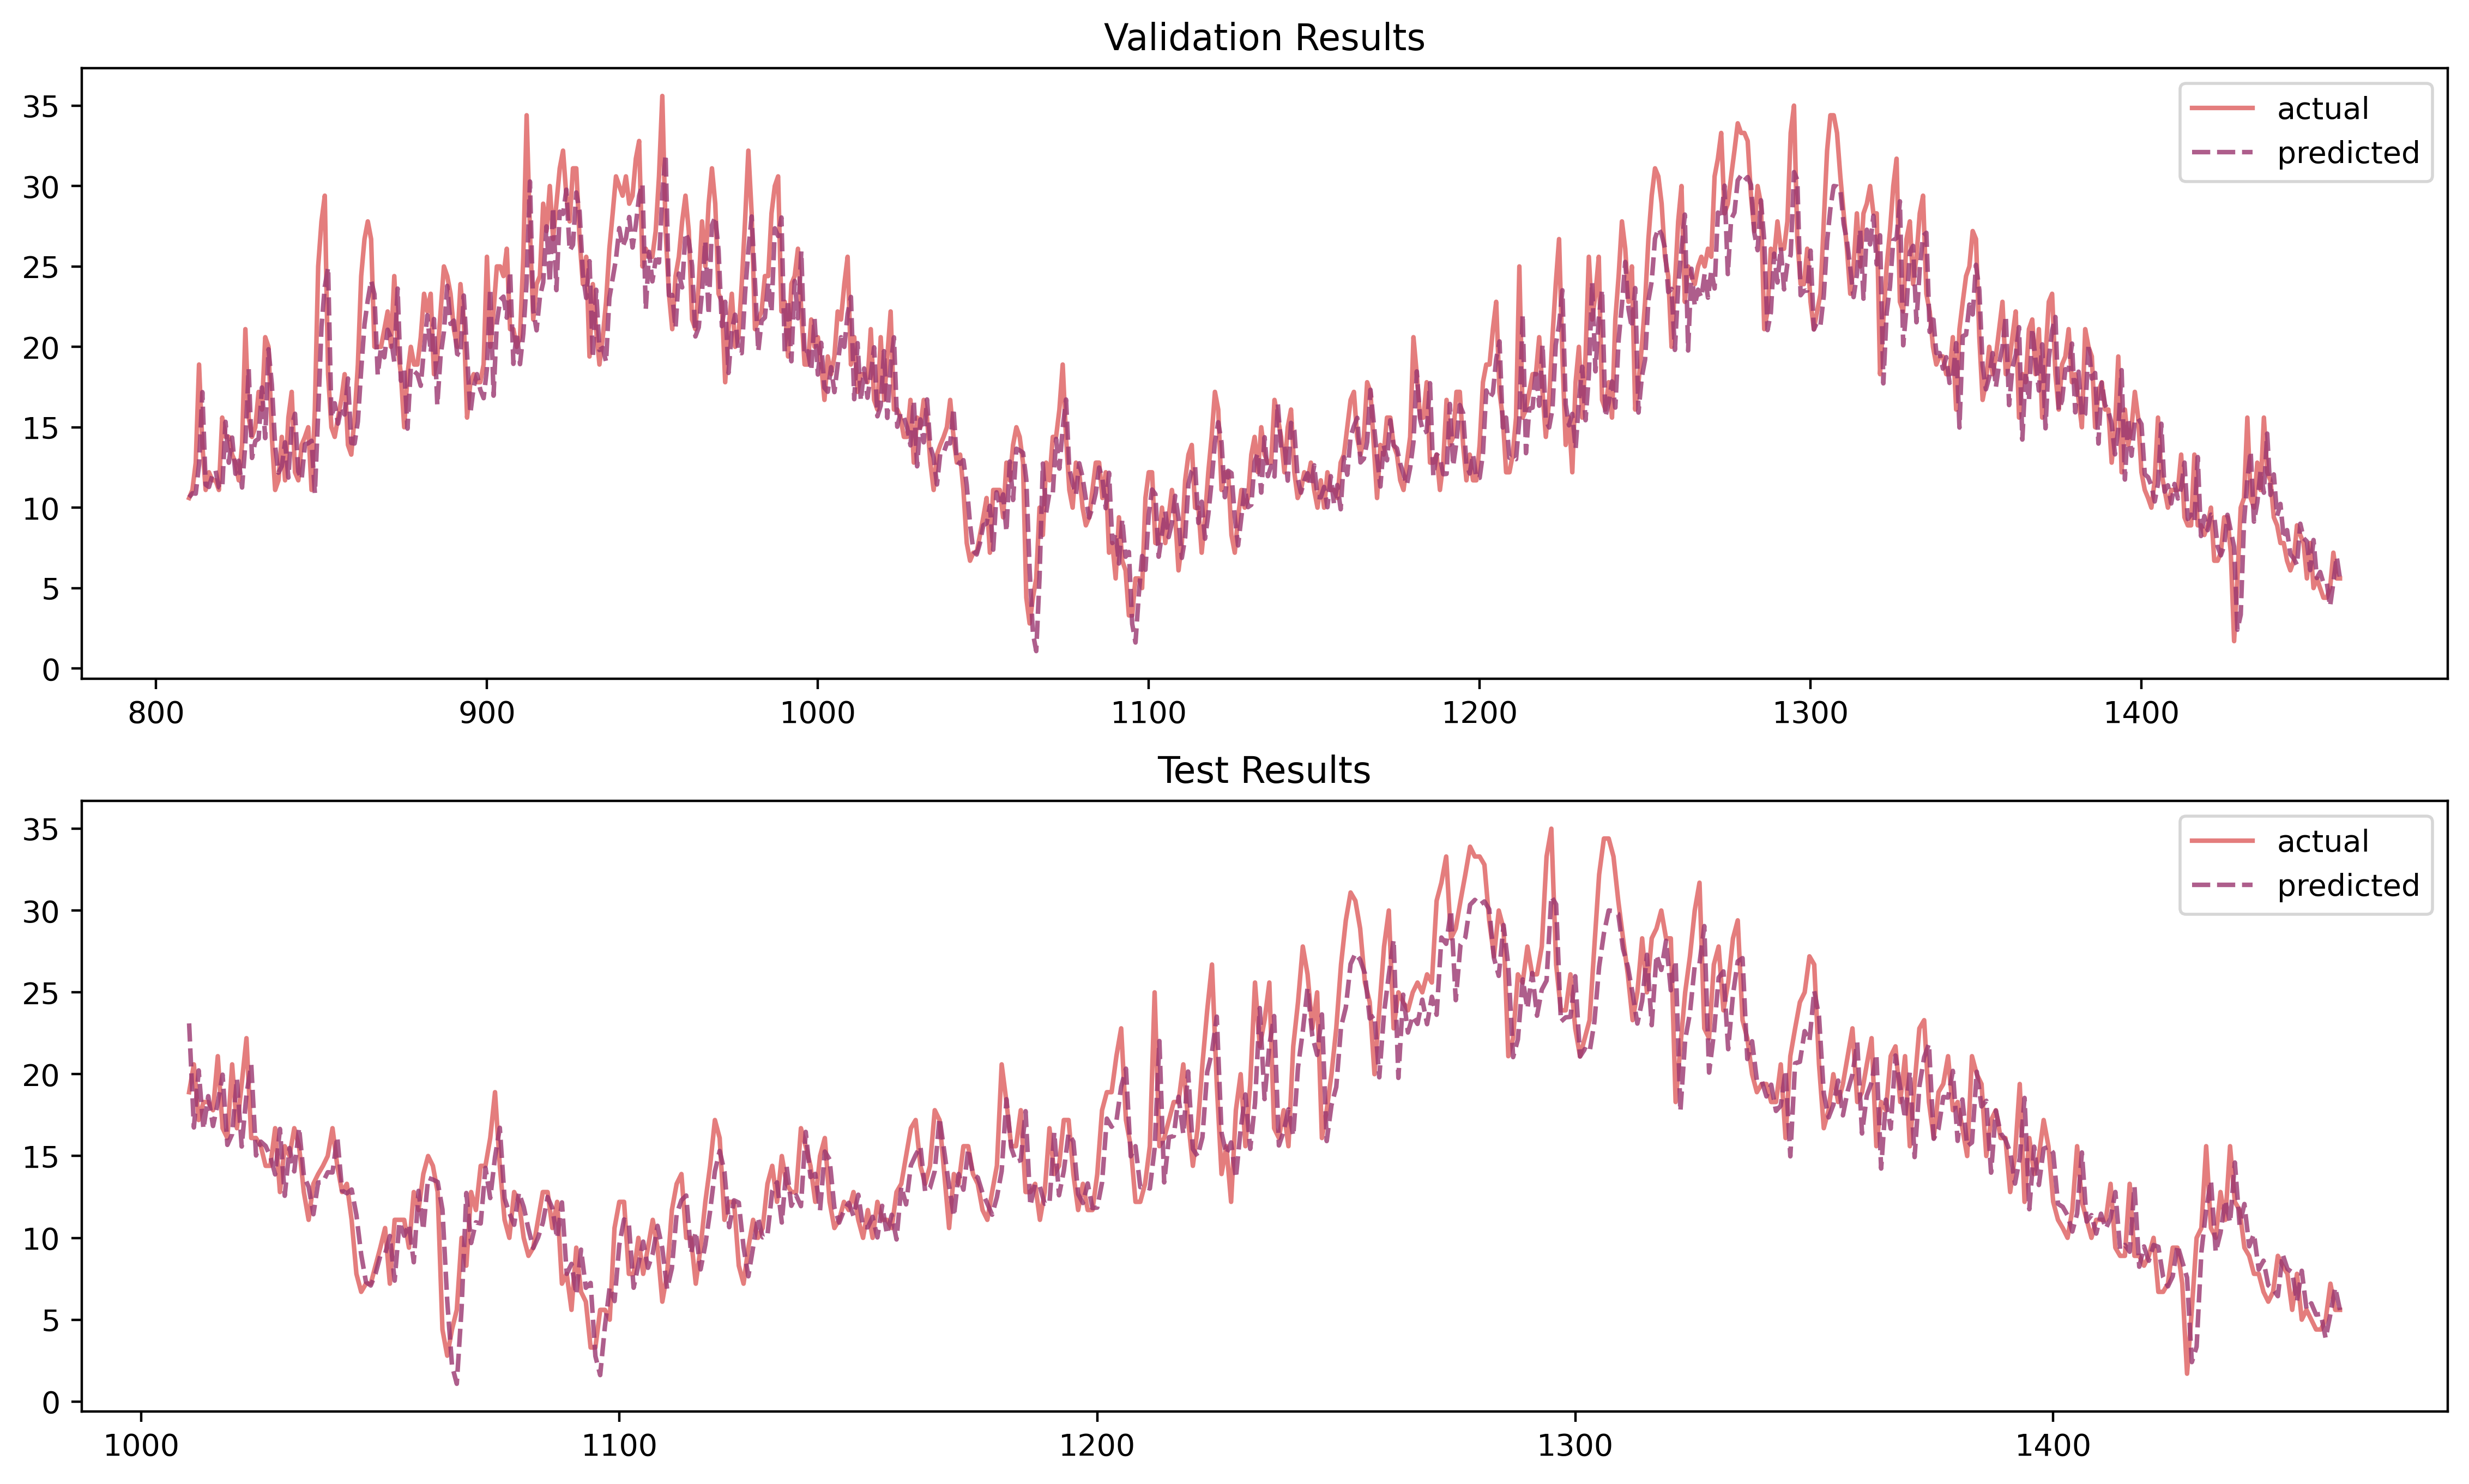

In [659]:
import matplotlib.pyplot as plt
import seaborn as sns

pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[10:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:],alpha=0.8,palette="flare",linestyle=None);